In [18]:
#libraries to work on our data
import pandas as pd
import numpy as np
from datetime import datetime

#financial dataset
import yfinance as yf

#libraries for plots
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

#functions for our correlation analysis
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

import statsmodels.stats.api as sms



## Load data
We load the data and edit the date to easily access yearly and daily data

In [19]:
Complete=pd.read_parquet('data/final_w_sentiment.parquet.gzip',engine='pyarrow')
# Split date and time into two columns
Complete[['date', 'time']] = Complete['date'].str.split(' ', 1, expand=True)

# Create a datetime variable
Complete['date_time'] = pd.to_datetime(Complete.date)

# Create a year column
Complete['year'] = pd.DatetimeIndex(Complete['date']).year
# sanity check
Complete.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,tokenized,cosine_similarity,sentiment,time,date_time,year
0,2015-12-09-000537,[ Starkman ] brings together the standards tha...,Jim Sleeper,[Q6198163],2015-12-09,1,[http://yaledailynews.com/blog/2015/12/09/visi...,starkman bring togeth standard journal alway t...,0.270932,positive,06:58:15,2015-12-09,2015
1,2015-02-06-023128,"However, (the) RRR cut has little to do with l...",Steven Zhu,[Q17649109],2015-02-06,4,[http://uk.reuters.com/article/2015/02/06/chin...,howev rrr cut littl loan underwrit control pbo...,0.275330,negative,03:49:04,2015-02-06,2015
2,2015-10-28-001053,[ Young savers' ] parents and grandparents are...,Patrick Connolly,[Q7146267],2015-10-28,1,[http://gulfnews.com/business/sectors/features...,young saver parent grandpar use higher interes...,0.209020,positive,07:26:15,2015-10-28,2015
3,2015-02-13-000112,2014 was a milestone year for us on many front...,Mike Fries,[Q54861319],2015-02-13,1,[http://advanced-television.com/2015/02/13/lib...,2014 mileston year us mani front we increas pa...,0.209020,positive,13:01:44,2015-02-13,2015
4,2015-03-09-000279,"a breeding ground for billion-pound companies,...",Elizabeth Anderson,"[Q15945136, Q43392130, Q43393308, Q43395340, Q...",2015-03-09,1,[http://www.cambridgenetwork.co.uk/news/is-cam...,breed ground billionpound compani spur uniqu c...,0.246626,positive,00:00:00,2015-03-09,2015


Build WordCloud for the selected quotes

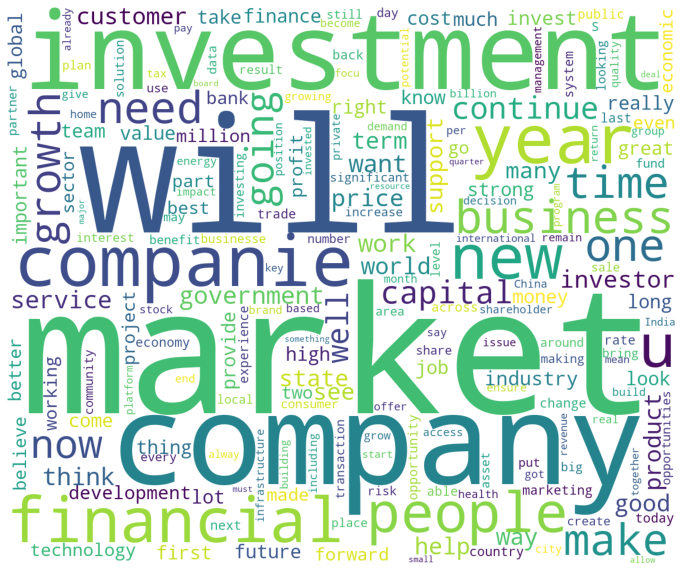

In [20]:
bigstring = Complete.quotation.apply(lambda x: ''.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='white',
                     collocations=False,
                     width=1200,
                     height=1000
                     ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

Plot the time series of the distribution of the sentiment

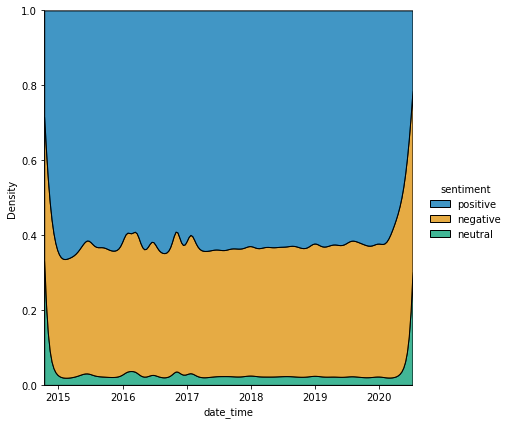

In [21]:
sn.displot(data=Complete, x='date_time', hue='sentiment', kind='kde', height=6, multiple='fill', clip=(0,None), palette='colorblind')

In [22]:
Complete.loc[Complete['sentiment'] == 'positive', 'sentiment'] = 1
Complete.loc[Complete['sentiment'] == 'negative', 'sentiment'] = -1
Complete.loc[Complete['sentiment'] == 'neutral', 'sentiment'] = 0

WordCloud for quotations classified as positive

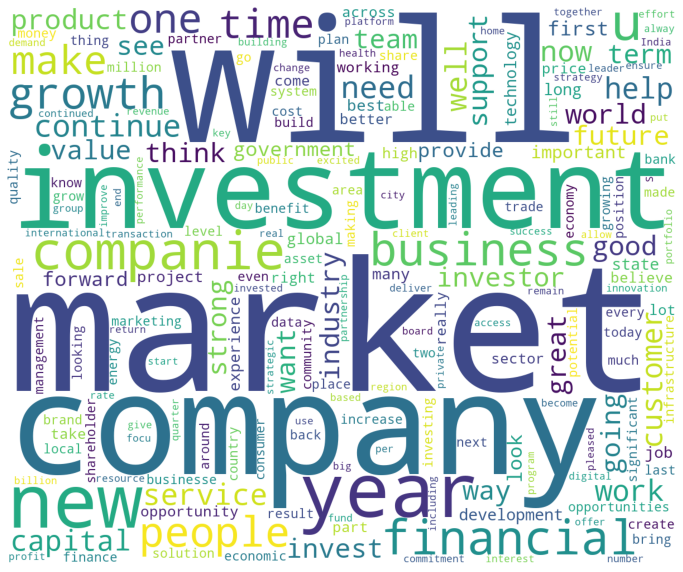

In [23]:
bigstring = Complete[Complete['sentiment'] == 1].quotation.apply(lambda x: ''.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='white',
                     collocations=False,
                     width=1200,
                     height=1000
                     ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

WordCloud for quotations classified as negative

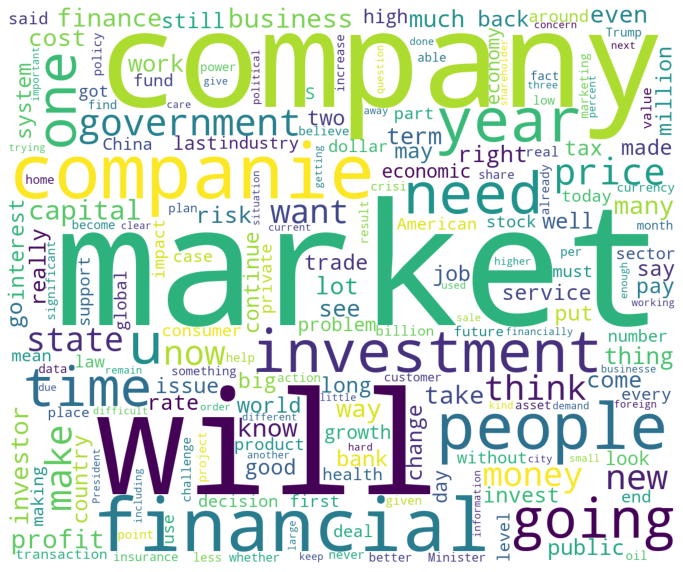

In [24]:
bigstring = Complete[Complete['sentiment'] == -1].quotation.apply(lambda x: ''.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='white',
                     collocations=False,
                     width=1200,
                     height=1000
                     ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

WordCloud for quotations classified as neutral

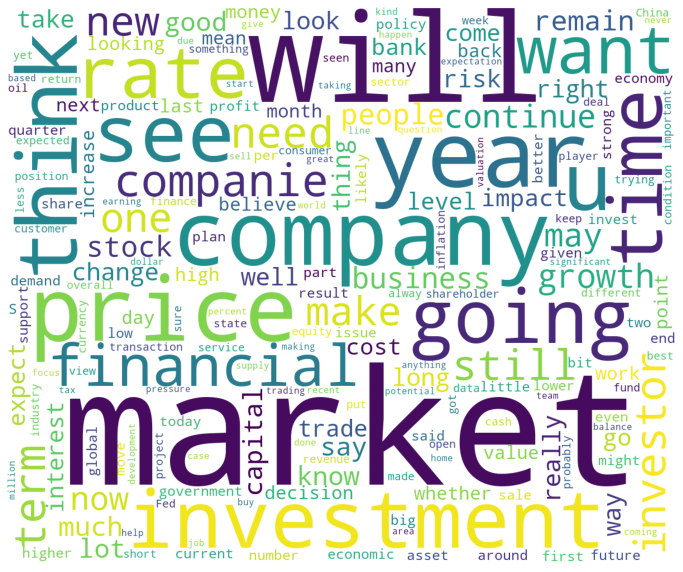

In [25]:
bigstring = Complete[Complete['sentiment'] == 0].quotation.apply(lambda x: ''.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='white',
                     collocations=False,
                     width=1200,
                     height=1000
                     ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

## Visualization of sentiments over time

In [26]:
# group data, compute daily confidence intervals
groups = Complete.groupby(['date'])['sentiment'].groups
confidences = np.asarray([list(sms.DescrStatsW(sentiments).tconfint_mean(alpha=0.05)) for sentiments in [np.asarray(Complete['sentiment'][groups[key]]) for key in groups.keys() if len(key) > 0]])
# Set up new dataframe with re-grouped data
dates = pd.DataFrame(confidences, index=groups.keys(), columns=['min','max'])
dates['mean'] = Complete.groupby(['date'])['sentiment'].mean()

/home/simon/anaconda3/envs/ada/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning:

invalid value encountered in double_scalars



In [27]:
dates['max_max'] = dates['max'] - dates['mean']
# dates['min_min'] = dates['mean']
fig = px.line(x=dates.index,y=dates['mean'], error_y=dates['max_max'])

fig = go.Figure([
    go.Scatter(
        x=dates.index,
        y=dates['mean'],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        name='Upper Bound',
        x=dates.index,
        y=dates['max'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=dates.index,
        y=dates['min'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(showlegend=False, title={'text': 'Detected overall Market sentiment','y':0.9, 'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()


# Quotation data wrangling

We fist take the first 200 people selected on the number of quotes

In [28]:
popular=Complete.groupby(by='speaker').date.count().to_frame()
popular=popular.date.sort_values(ascending=False)[:200]
popular=popular.to_frame().reset_index()
pop=popular.speaker.str.split(expand=True)

First step is to see if there are some people with more than two words in their name

In [29]:
pop[pop[2].notnull()]

,0,1,2,3
0,President,Donald,Trump,None
25,President,Barack,Obama,None
39,Lim,Guan,Eng,None
56,John,Mackey,",",None
67,Ravi,Shankar,Prasad,None
81,Prime,Minister,Theresa,May
90,Bill,de,Blasio,None
114,Nana,Addo,Dankwa,Akufo-Addo
146,Bruno,Le,Maire,None
160,Recep,Tayyip,Erdogan,None


We can observe that there are some people with titles (like President or Prime Minister) and so we check if these people were called also in other ways in the quotebank

In [30]:
popular[popular.speaker.str.contains('Trump')]

,speaker,date
0,President Donald Trump,10126
4,Donald Trump,6330
5,President Trump,4492
150,Ivanka Trump,757


In [31]:
popular[popular.speaker.str.contains('Obama')]

,speaker,date
25,President Barack Obama,1934
42,President Obama,1438


In [32]:
popular[popular.speaker.str.contains('May')]

,speaker,date
40,Theresa May,1537
81,Prime Minister Theresa May,1103


In [33]:
popular[popular.speaker.str.contains('Rick')]

,speaker,date
163,Gov. Rick Scott,727


As we can notice from this first analysis Trump has three different names, Obama 2 and May 2.
Now we are going to check if there are some people with same surname 

In [34]:
pop[pop[1].duplicated(keep=False)]

,0,1,2,3
4,Donald,Trump,None,None
5,President,Trump,None,None
28,Neil,Wilson,None,None
51,Imran,Khan,None,None
52,Sherrod,Brown,None,None
59,Andrew,Wilson,None,None
64,Sadiq,Khan,None,None
90,Bill,de,Blasio,None
117,Rajnish,Kumar,None,None
120,Chandrababu,Naidu,None,None


As we can notice all the other people with same surname have different names so the only problem were the people with titles before their names consequently we are going to call all the string containing president Trump or donald trump as Donald Trump. We then do the same for Theresa May and Barack Obama 

In [35]:
Complete.speaker=Complete.speaker.str.replace('Prime Minister ','')
Complete.speaker=Complete.speaker.str.replace('President Donald Trump','Donald Trump')
Complete.speaker=Complete.speaker.str.replace('President Trump','Donald Trump')
Complete.speaker=Complete.speaker.str.replace('President Obama','Barack Obama')
Complete.speaker=Complete.speaker.str.replace('President Barack Obama','Barack Obama')

Now we are going to keep only the first 100 people basing on the number of quotes

In [36]:
top100=Complete[Complete.speaker.isin(Complete.speaker.value_counts()[:100].index.tolist())]

In [37]:
#top100.to_csv('top100.csv')

We now present the people with the highest number of quotes

In [38]:
a=top100.groupby(by='speaker',as_index=False).count().sort_values(by='date',ascending=False)
fig = px.bar(a[0:20], y="speaker", x="date", color='speaker',height=500,labels={
                     "day": "Number of quotations",
                 },)
fig.update_layout(title_text='20 most quotated people', title_x=0.46)
fig.write_html('speakers.html')
fig.show()

### Now we are going to concentrate on the financial dataset

We first check which are the dates of first and last quote 

In [39]:
top100.date.min()

'2015-01-01'

In [40]:
top100.date.max()

'2020-04-16'

In [41]:
SP500=yf.download('SPY', start='2015-01-01', end='2020-04-16')
SP500

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,207.990005,208.190002,205.389999,205.539993,181.073105,130333800
2015-01-02,206.380005,206.880005,204.179993,205.429993,180.976273,121465900
2015-01-05,204.169998,204.369995,201.350006,201.720001,177.707855,169632600
2015-01-06,202.089996,202.720001,198.860001,199.820007,176.034058,209151400
2015-01-07,201.419998,202.720001,200.880005,202.309998,178.227661,125346700
...,...,...,...,...,...,...
2020-04-08,267.959991,276.000000,265.250000,274.029999,267.966888,153774500
2020-04-09,277.579987,281.200012,275.470001,278.200012,272.044647,189999200
2020-04-13,277.140015,277.510010,271.410004,275.660004,269.560822,114839100


We are going to keep only the Close and Open columns and the volume one, we don't keep the adj close because is connected to dividend distributions and it's not relevant for our studies, we also reset index because the dates are relevant for our studies

In [42]:
SP500=SP500.drop(['High','Low','Adj Close'],axis=1).reset_index()

Now because we need to see whether the sentiment of a quote have an impact on the market we are going to calculate a delta on the value of the day, to have an idea on how the value of S&P500 has changed during the day.

In [43]:
a=len(SP500)
SP500['day_variation']=np.insert(SP500['Open'].loc[1:a-1].values-SP500['Open'].loc[0:a-2].values, a-1,0)

In [44]:
SP500

,Date,Open,Close,Volume,day_variation
0,2014-12-31,207.990005,205.539993,130333800,-1.610001
1,2015-01-02,206.380005,205.429993,121465900,-2.210007
2,2015-01-05,204.169998,201.720001,169632600,-2.080002
3,2015-01-06,202.089996,199.820007,209151400,-0.669998
4,2015-01-07,201.419998,202.309998,125346700,2.589996
...,...,...,...,...,...
1326,2020-04-08,267.959991,274.029999,153774500,9.619995
1327,2020-04-09,277.579987,278.200012,189999200,-0.439972
1328,2020-04-13,277.140015,275.660004,114839100,3.839996
1329,2020-04-14,280.980011,283.790009,134143400,-3.410004


In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=SP500['Date'], y=SP500['day_variation'], mode='lines', name='day_variation'))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title_text="Day_variation", 
    title_x=0.48,
    xaxis_title="Days")
fig.write_html("day_variation.html")
fig.show()

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=SP500['Date'], y=SP500['Volume'],
                    mode='lines',
                    name='SP500',
                    marker = {'color' : 'red'}))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title_text="Volume", 
    title_x=0.48,
    xaxis_title="Days")
fig.write_html("Volume.html")
fig.show()

In [47]:
Fin=pd.read_csv('SP500_adj1.csv')
Fin=Fin.drop(['Unnamed: 0','delta_volume'],axis=1)
Fin

FileNotFoundError: [Errno 2] No such file or directory: 'SP500_adj1.csv'

### Day value stock variation vs Volume variation

We want also to compare the two different values of the stock dataset we used for our analysis to understand more about the reasons why we obtained different results from the two analysis

In [ ]:
Fin['Vol_perc']=Fin.Volume.pct_change()
Fin['day_v_perc']=Fin.Open.pct_change()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['Vol_perc'],
                    mode='lines',
                    name='SP500 volume variation percentage'))
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['day_v_perc'],
                    mode='lines',
                    name='SP500 price variation percentage'))

fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html('stock_value_varuiation_vs_volume_variation.html')

As we can see from the plot the stock market didn't really have huge day variations because it is composed by many companies and it could happened that when some companies go down others go up. For this reason the two analysis have given different results.

### Now we are ready to work on our correlation analysis

To make the codes coincides

In [ ]:
Quotes=top100.rename(columns={'date':'day','sentiment':'numsentiment'})

In [ ]:
Quotes

In [ ]:
Quotes=Quotes.drop(['date_time','quoteID','quotation','qids','numOccurrences','urls','tokenized','cosine_similarity','time','year'],axis=1)
Quotes

Here we have to put the date of the quotes told in days when the market was closed equal to the first day when the market was open

To find those dates we first do an outer merge with the financial dataset

In [ ]:
Q=pd.merge(Quotes,Fin,left_on='day',right_on='Date',how='outer')
Q

For each date when there is a quote but the market was closed we take the smallest date between the dates that are bigger than the date of the quote

In [ ]:
from tqdm import tqdm
tqdm.pandas()
day=Q[Q.Date.isna()].day.progress_apply(lambda x: Q[(Q.Date>x) & (Q.Date.notnull())].Date.min())

In [ ]:
idx=day.to_frame().index

In [ ]:
Q.day.loc[idx]=day

now we are going to sort the dates of both the dataframe to have a corrispondance between the two dataframes and then we allocate the new values we have found in the old dataframe to solve the issue

In [ ]:
Quotes=Quotes.sort_values('day')

In [ ]:
Quotes.day=pd.merge(Q[Q.day.notnull()],Fin,left_on='day',right_on='Date').sort_values('day').day.values

Now we have to check if everithing worked properly firstly we see if there are any dates that are in the quotes data frame that are not in the Fin

In [ ]:
print(len(Quotes))
print(len(pd.merge(Quotes,Fin,left_on='day',right_on='Date')))

They are the same so it could have worked, but now we have to verify if the dates are right to do so we reopen the starting dataset and we merge it with our and see if the dates differ only for few days

In [ ]:
pd.merge(Quotes,top100,left_index=True,right_index=True).sample(40)

As we can see from the sample it worked well because comparing the days they differ at maximum of 2 days

### Creating the columns for our analysis

We compute a sum of the sentiments of the same days told by each person. This value will be useful for the first analysis

In [ ]:
Quot=Quotes.groupby(by=['speaker','day'])['numsentiment'].sum().to_frame().reset_index()
Quot

Here we are going to see which is the number of positive or negative sentences that a person said during each day, this will be useful for the analysis on the volumes

In [ ]:
numposneg=Quotes[Quotes.numsentiment!='neutral'].groupby(by=['speaker','day'])['numsentiment'].count().to_frame().rename(columns={'numsentiment':'numposneg'})
numposneg

In [ ]:
Quot_vol=pd.merge(Quot,numposneg,left_on=['speaker','day'],right_index=True)
Quot_vol

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,6))
sn.boxplot(data=Fin, x='Volume',ax=ax)
plt.show()
plt.savefig('boxplot_volume.png')

We want to create also a dataframe without the outliers for volume values for our analysis because from the boxplot we have notice that there are many outliers and we don't want them to bias our analysis

In [ ]:
q1 = Fin.Volume.quantile(0.25)
q3 = Fin.Volume.quantile(0.75)
iqr = q3 - q1 #Interquartile range
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

In [ ]:
Fin2=Fin[(Fin.Volume>fence_low)&(Fin.Volume<fence_high)]

Here we are going to compute both our analysis, we will use spearman rank correlation to find a correlation between the sentiment expressed by each person and the day stock value variation.
For the second analysis we want to see whether the days when a person talked had an average volume bigger then the days when he didn't speak. To do so we compute a one side t test with the two averages

In [ ]:
speak=[]
Test1_Scoef=[]
Test1_Spval=[]
ttest=[]
ttest_noout=[]
for sp in Quot['speaker'].unique():
    ### This first part is to do the correlation between the sentiment of each speaker sentences and the delta of the
    ### stock
    temp=Quot[Quot['speaker']==sp] #to select a subset
    temp=pd.merge(temp,Fin, left_on='day', right_on='Date') #to have the correspondance between dates
    spear1=spearmanr(temp['numsentiment'],temp['day_variation'],nan_policy='omit') #spearman correlation
    
    #update the list of speakers
    speak.append(sp)
    
    #update the list of results of the first test
    Test1_Scoef.append(spear1.correlation)
    Test1_Spval.append(spear1.pvalue)
    
    #Test 2: t test with and without the outliers
    temp2=pd.merge(Quot_vol[Quot_vol.speaker==sp],Fin,left_on='day', right_on='Date',how='right')
    temp3=pd.merge(Quot_vol[Quot_vol.speaker==sp],Fin2,left_on='day', right_on='Date',how='right')
    temp2.numposneg=temp2.numposneg.fillna(0)
    temp3.numposneg=temp3.numposneg.fillna(0)
    #appending one side t test to the two lists
    ttest.append(ttest_ind(temp2.Volume[temp2.numposneg==0],temp2.Volume[temp2.numposneg!=0],alternative='less').pvalue)
    ttest_noout.append(ttest_ind(temp3.Volume[temp3.numposneg==0],temp3.Volume[temp3.numposneg!=0],alternative='less').pvalue)

    



In [ ]:
results=pd.DataFrame()
results['speaker']=speak
results['Test1_Scoef']=Test1_Scoef
results['Test1_Spval']=Test1_Spval
results['ttest']=ttest
results['ttest_noout']=ttest_noout

In [ ]:
fig = px.scatter(results, x="ttest_noout", y="Test1_Spval", color="Test1_Scoef",hover_name='speaker',
                 labels={"ttest_noout": "p value of t test related to average difference",
                         "Test1_Spval": "P value of spearman correlation",
                         "Test1_Scoef": "spearman correlation coefficient"})
fig.update_layout(title_text='Plot the relation between results',
                         title_x=0.25)
fig.show()
fig.write_html('plot_results.html')

We can notice that the results of the two tests are really differents in fact we can notice that there is no intersection between the two tests: there are no points with small p value in both the tests.

In [ ]:
results[(results.Test1_Spval<0.1)&(results.ttest_noout<0.1)]

In [ ]:
results[results.ttest_noout<0.1]

Now we are going to see if there is correlation between the number of positive or negative quotes of a person and the volume of the market in a single day

In [ ]:
speak=[]
Test1_Scoef=[]
Test1_Spval=[]
for sp in results[results.ttest_noout<0.1].speaker:
    temp=Quot_vol[Quot_vol['speaker']==sp] #to select a subset
    temp=pd.merge(temp,Fin2, left_on='day', right_on='Date') #to have the correspondance between dates
    spear1=spearmanr(temp['numposneg'],temp['Volume'],nan_policy='omit')
    speak.append(sp)
    Test1_Scoef.append(spear1.correlation)
    Test1_Spval.append(spear1.pvalue)
    

In [ ]:
most_popular=pd.DataFrame()
most_popular['speaker']=speak
most_popular['Test1_Scoef']=Test1_Scoef
most_popular['Test1_Spval']=Test1_Spval

In [ ]:
most_popular

Almost all the people that had a p value of the t test small enough have a positive correlation between the number of sentences they say and the volume of stock shared in that day, only Richard Cordray doesn't result positive correlated, which means that maybe he doesn't really have an impact on the market.

Now we are going to vizualize the developement of different people's number of positive or negative sentences over the number of volume of shares per day

Before doing it we have to find a good way to visualize our results, log scale on y axes doesn't work because we don't see the changes between the two, so we decided to standardize our data just because we don't really care about variables values but we only want to see if they increase or decrease

In [ ]:
Fin['volume_plot']=(Fin['Volume']-Fin['Volume'].mean())/Fin['Volume'].std()
Quot_vol['numposneg_plot']=(Quot_vol['numposneg']-Quot_vol['numposneg'].mean())/Quot_vol['numposneg'].std()

### Barack Obama

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['volume_plot'],line=dict(color='#4682B4'),
                    mode='lines',
                    name='Volume'))
fig.add_trace(go.Scatter(x=Quot_vol[Quot_vol['speaker']=='Barack Obama']['day'],
                         y=Quot_vol[Quot_vol['speaker']=='Barack Obama']['numposneg_plot'],
                         line=dict(color='#B8860B'),
                    mode='lines+markers',
                    name='number of positive or negative sentences'))
fig.update_layout(title_text='Obama number of sentences related to volume variation',
                         title_x=0.13,legend=dict( yanchor="top", y=0.99, xanchor="right",x=0.99))
#fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")
#fig.update_yaxes(range=[0.5, 10])
fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html('Barack_Obama_volume_changed_vs_number_quotes.html')

trying to see if he influenced more the market when he was president

In [ ]:
old=Quot_vol[(Quot_vol.day<'2018-01-01')&(Quot_vol.speaker=='Barack Obama')]
new=Quot_vol[(Quot_vol.day>='2018-01-01')&(Quot_vol.speaker=='Barack Obama')]
old=pd.merge(old,Fin2,left_on='day', right_on='Date')
new=pd.merge(new,Fin2,left_on='day', right_on='Date')
print(spearmanr(old['numposneg'],old['Volume'],nan_policy='omit'))
print(spearmanr(new['numposneg'],new['Volume'],nan_policy='omit'))

### David Cameron

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['volume_plot'],line=dict(color='#4682B4'),
                    mode='lines',
                    name='Volume'))
fig.add_trace(go.Scatter(x=Quot_vol[Quot_vol['speaker']=='David Cameron']['day'],
                         y=Quot_vol[Quot_vol['speaker']=='David Cameron']['numposneg_plot'],
                         line=dict(color='#B8860B'),
                    mode='lines+markers',
                    name='number of positive or negative sentences'))
fig.update_layout(title_text='Cameron number of sentences related to volume variation',
                         title_x=0.13, legend=dict( yanchor="top", y=0.99, xanchor="right",x=0.99))
#fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")
#fig.update_yaxes(range=[0.5, 10])

fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html('David_Cameron_volume_changed_vs_number_quotes.html')

### George Osborne

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['volume_plot'],line=dict(color='#4682B4'),
                    mode='lines',
                    name='Volume'))
fig.add_trace(go.Scatter(x=Quot_vol[Quot_vol['speaker']=='George Osborne']['day'],
                         y=Quot_vol[Quot_vol['speaker']=='George Osborne']['numposneg_plot'],
                         line=dict(color='#B8860B'),
                    mode='lines+markers',
                    name='number of positive or negative sentences'))
fig.update_layout(title_text='Osborne number of sentences related to volume variation',
                         title_x=0.13,legend=dict( yanchor="top", y=0.99, xanchor="right",x=0.99))
#fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")
#fig.update_yaxes(range=[0.5, 10])
fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html('George_Osborne_volume_changed_vs_number_quotes.html')

### Hillary Clinton

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Fin['Date'], y=Fin['volume_plot'],line=dict(color='#4682B4'),
                    mode='lines',
                    name='Volume'))
fig.add_trace(go.Scatter(x=Quot_vol[Quot_vol['speaker']=='Hillary Clinton']['day'],
                         y=Quot_vol[Quot_vol['speaker']=='Hillary Clinton']['numposneg_plot'],
                         line=dict(color='#B8860B'),
                    mode='lines+markers',
                    name='number of positive or negative sentences'))
fig.update_layout(title_text='Clinton number of sentences related to volume variation',
                         title_x=0.13,legend=dict( yanchor="top", y=0.99, xanchor="right",x=0.99))
#fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")
#fig.update_yaxes(range=[0.5, 10])
fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html('Hillary_Clinton_volume_changed_vs_number_quotes.html')